In [29]:
import pandas as pd
import numpy as np

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt


In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [33]:
import joblib

%matplotlib inline
sns.set(style="whitegrid")

In [34]:
df = pd.read_csv("iris.csv")

In [35]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [37]:
df.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [38]:
df.isnull().sum()


Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [39]:
df.columns


Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

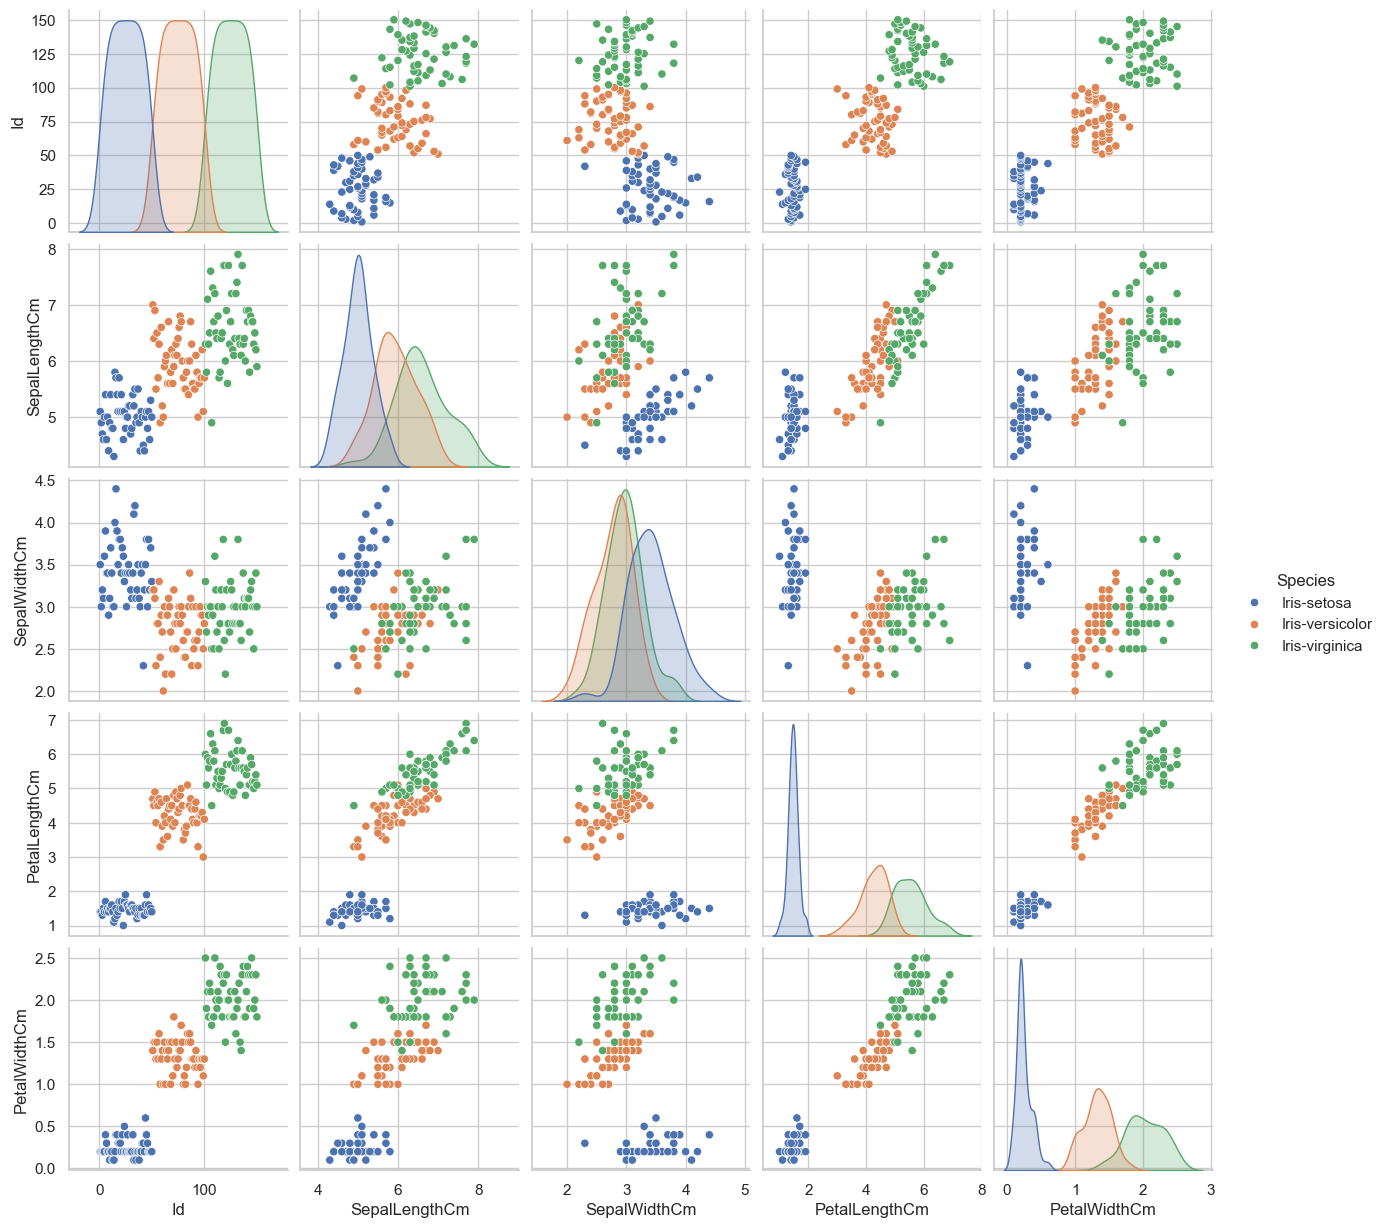

In [40]:
sns.pairplot(df, hue='Species')
plt.show()


In [41]:
df = df.drop(columns=['Id'])


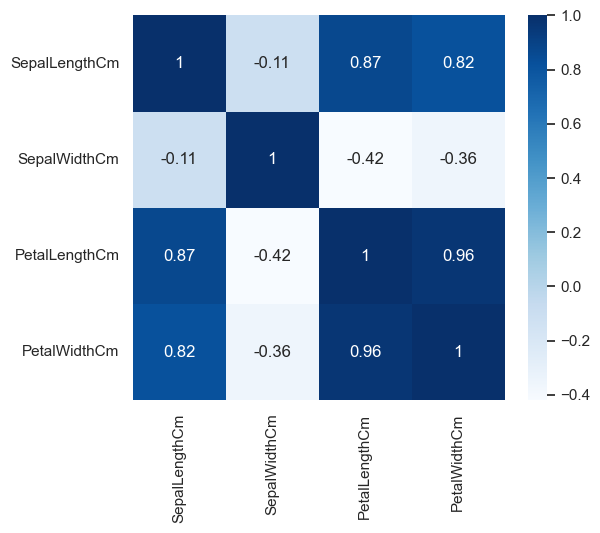

In [42]:
plt.figure(figsize=(6,5))
sns.heatmap(df.select_dtypes(include=['float64','int64']).corr(), annot=True, cmap='Blues')
plt.show()


In [43]:
X = df.drop("Species", axis=1)
y = df["Species"]


In [44]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
le.classes_


array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train.shape, X_test.shape


((120, 4), (30, 4))

In [46]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

results = {}

for name, model in models.items():
    pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
    results[name] = scores.mean()

results


{'Logistic Regression': 0.9583333333333334,
 'KNN': 0.9666666666666668,
 'Decision Tree': 0.9416666666666668,
 'Random Forest': 0.95,
 'SVM': 0.9666666666666668}

In [47]:
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier())
])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("ACCURACY:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


ACCURACY: 0.9
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.82      0.90      0.86        10
 Iris-virginica       0.89      0.80      0.84        10

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



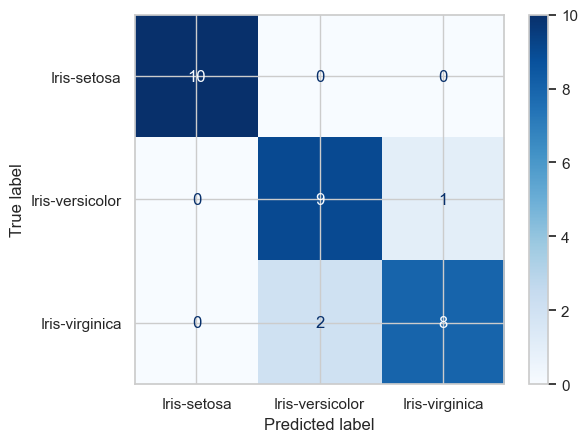

In [48]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.show()


In [49]:
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [None, 3, 5],
    "model__min_samples_split": [2, 4]
}

grid = GridSearchCV(best_model, param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Best Params: {'model__max_depth': None, 'model__min_samples_split': 4, 'model__n_estimators': 200}
Best CV Accuracy: 0.9583333333333334


In [50]:
joblib.dump({"model": grid.best_estimator_, "label_encoder": le}, "iris_classifier.pkl")
print("Model saved as iris_classifier.pkl")


Model saved as iris_classifier.pkl


In [51]:
saved = joblib.load("iris_classifier.pkl")
model = saved["model"]           # this is your trained pipeline
encoder = saved["label_encoder"]

# Create a sample as a DataFrame with the same feature names as training
sample = pd.DataFrame(
    [[5.1, 3.5, 1.4, 0.2]],
    columns=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
)

# Predict
pred = model.predict(sample)

# Decode numeric label to species name
print("Predicted Species:", encoder.inverse_transform(pred)[0])

Predicted Species: Iris-setosa
